In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Pooled model

In [2]:
path = r"D:\misc\code\bayesian_retry\retry\points_df.csv"
points_df = pd.read_csv(path, index_col=0)
points_df

,total,home,away,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),...,ZSC Lions (away),HC Ambri-Piotta (home),SC Bern (away),EV Zug (away),Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away)
HC Ajoie,89,53,36,7.0,14.0,13.0,4.0,8.0,13.0,7.0,...,10.0,5.0,8.0,8.0,7.0,11.0,12.0,7.0,0.0,0.0
EHC Biel-Bienne,168,91,77,0.0,2.0,15.0,2.0,6.0,7.0,3.0,...,15.0,6.0,9.0,4.0,8.0,0.0,4.0,5.0,2.0,1.0
SC Bern,136,75,61,11.0,4.0,4.0,7.0,0.0,7.0,7.0,...,2.0,6.0,0.0,5.0,5.0,14.0,5.0,11.0,3.0,1.0
Fribourg-Gottéron,185,104,81,4.0,4.0,18.0,3.0,3.0,6.0,4.0,...,9.0,8.0,7.0,7.0,5.0,5.0,3.0,15.0,1.0,4.0
ZSC Lions,210,117,93,15.0,6.0,0.0,4.0,8.0,16.0,7.0,...,0.0,2.0,4.0,13.0,6.0,8.0,4.0,7.0,8.0,4.0
Genève-Servette HC,155,82,73,4.0,9.0,11.0,13.0,7.0,6.0,0.0,...,1.0,3.0,2.0,4.0,0.0,7.0,1.0,5.0,7.0,5.0
EV Zug,223,127,96,5.0,9.0,5.0,6.0,7.0,0.0,9.0,...,13.0,7.0,3.0,0.0,7.0,7.0,5.0,7.0,3.0,3.0
HC Davos,169,91,78,2.0,2.0,11.0,3.0,6.0,18.0,2.0,...,6.0,5.0,4.0,6.0,6.0,5.0,15.0,4.0,6.0,0.0
HC Lugano,175,87,88,8.0,0.0,10.0,4.0,5.0,24.0,7.0,...,7.0,6.0,3.0,22.0,7.0,8.0,3.0,12.0,5.0,2.0
SC Rapperswil-Jona Lakers,182,103,79,7.0,7.0,8.0,6.0,6.0,3.0,3.0,...,10.0,6.0,4.0,3.0,6.0,5.0,0.0,4.0,5.0,5.0


In [18]:
x = np.concatenate(points_df.iloc[:, 3:].values)[:330].reshape(11,30) # cut to have corret shapes
y = points_df.iloc[:11, :3].values.astype(np.float64).T

mu_y = y.mean()
s_y = y.std()
s_x = x.std()
x.shape,y.shape

((11, 30), (3, 11))

In [19]:
# model
with pm.Model() as pooled_model:
    # priors:
    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=30)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x, beta)

    y_pred = pm.StudentT ('y_pred', nu=3.6, mu=mu, sd=sigma, observed=y)

    # inference:
    trace_pooled = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


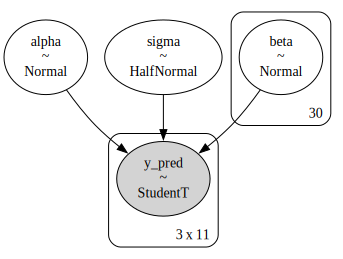

In [20]:
pm.model_to_graphviz(pooled_model)

## Checking convergence

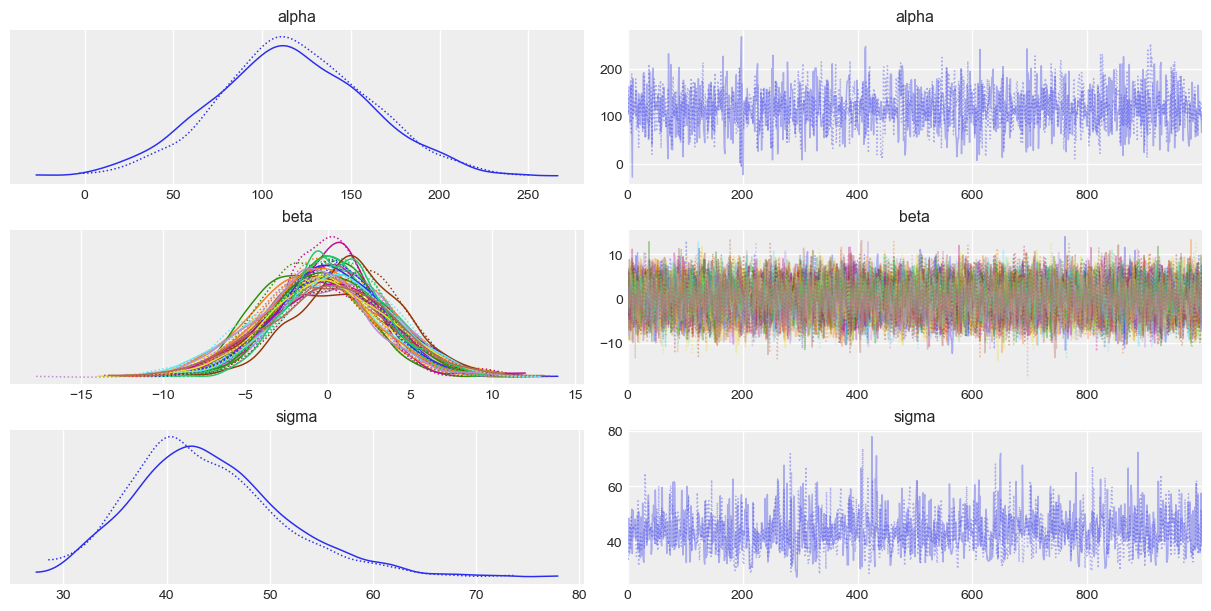

In [21]:
with pooled_model:
    az.plot_trace(trace_pooled);

In [22]:
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,116.843,43.046,37.428,201.838,0.929,0.681,2152.0,1227.0,1.00
beta[0],0.216,3.171,-5.995,5.784,0.086,0.069,1362.0,1318.0,1.00
beta[1],-1.154,3.475,-7.812,5.354,0.089,0.081,1519.0,1180.0,1.00
beta[2],-1.215,3.073,-7.162,4.235,0.082,0.061,1387.0,1553.0,1.00
beta[3],-0.119,2.597,-4.870,4.922,0.080,0.061,1067.0,1143.0,1.01
beta[4],0.127,3.715,-7.235,6.644,0.091,0.086,1659.0,1344.0,1.00
beta[5],-0.239,3.311,-6.627,5.838,0.086,0.067,1471.0,1414.0,1.00
beta[6],0.012,3.748,-7.524,6.927,0.087,0.083,1881.0,1296.0,1.00
beta[7],0.634,3.158,-5.369,6.469,0.090,0.070,1216.0,1300.0,1.00
beta[8],0.629,3.364,-4.915,7.904,0.086,0.073,1521.0,1193.0,1.00


## Predictive checks

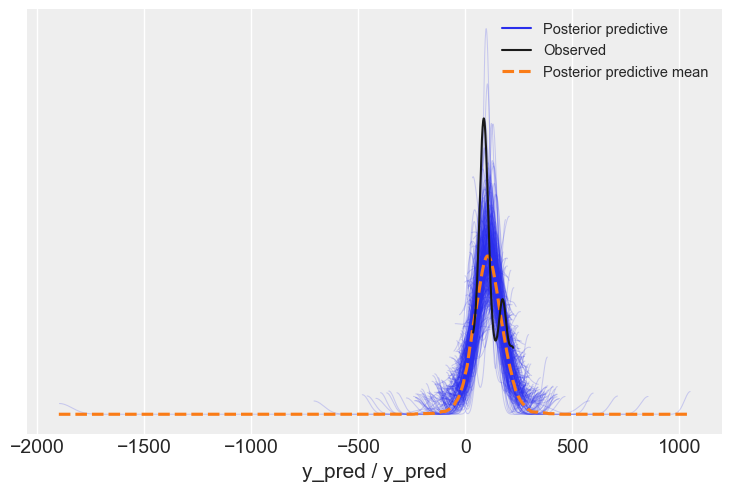

In [23]:
with pooled_model:
     ppc = pm.sample_posterior_predictive(trace_pooled, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pooled_model));

### mean HC Lugano

In [24]:
x_hcl = np.array(x)[9, :]
x_hcl

array([18.,  8.,  3., 14.,  0.,  6.,  5.,  7.,  5.,  4.,  9.,  6., 10.,
        0.,  3.,  4.,  9., 12., 10.,  7., 11., 11., 14.,  9.,  0.,  9.,
        9., 10.,  0.,  5.])

In [25]:
post_pool = az.extract_dataset(trace_pooled.posterior)
alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 30)
mu_team = alpha_samples + np.dot(x_hcl, beta_samples.T)

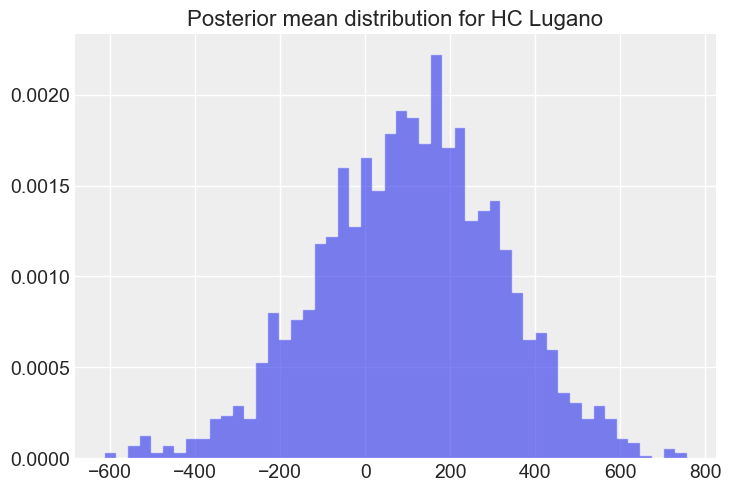

HC Lugano predicted mean: 105.227
HC Lugano predicted mean standard deviation: 214.588


In [26]:
# plot the posterior predictive distribution
plt.hist(mu_team, bins=50, density=True, histtype='stepfilled', alpha=0.6)
plt.title('Posterior mean distribution for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team.std():.3f}')

### prediction for next game

In [27]:
post_pool = az.extract_dataset(trace_pooled.posterior)

alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 30)
sigma_samples = post_pool.sigma.values.reshape(2000)

In [28]:
x_hcl_test = x[0].ravel()

predictive_distribution = []

for i in range(len(alpha_samples)):
    mu_team = alpha_samples[i] + np.dot(x_hcl_test, beta_samples[i])
    y_pred = np.random.normal(mu_team, sigma_samples[i])

    y_pred = np.random.normal(loc=mu_team, scale=sigma_samples[i])
    predictive_distribution.append(y_pred)

Text(0.5, 1.0, "Prediction for HC Lugano's points next season")

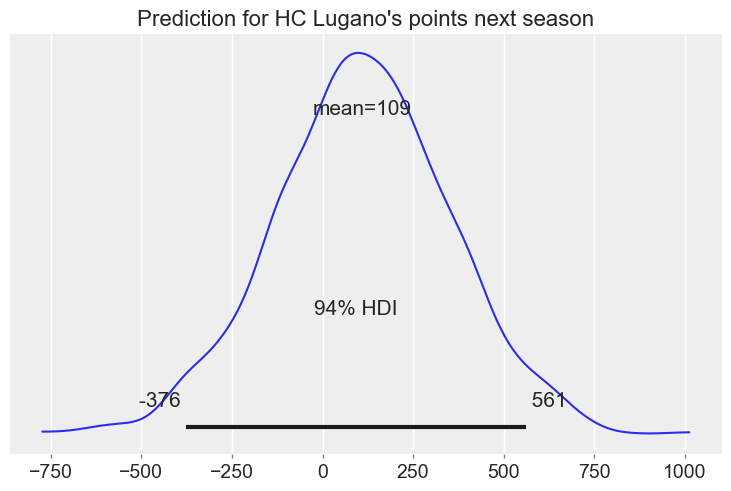

In [30]:
az.plot_posterior(np.array(predictive_distribution))
plt.title("Prediction for HC Lugano's points next season")